# Building a Goodreads recommendation system
**Capstone Project 2 Final Report**

## Background

Goodreads is a social media platform that allows users to rate and review books as well as see what their friends are reading, rating, and reviewing.

Users can use the platform to keep track of the books that they have read while also identifying books they'd like to read next. In addition to pulling reading recommendations from their friends' profiles, they can also receive book recommendations through the Goodreads recommender system. However, based on personal experience, the system does not always offer the most helpful suggestions. Most of the books it recommends are obscure and do not appear to be based on what a user previously rated or what their friends have read. 

Seeing as Amazon purchased Goodreads in 2013, this seems like a huge missed opportunity to provide useful book recommendations that could turn into book sales.  

Is it possible to create a more useful recommendation system for readers? 

## The Data 

To answer this question I will be using the Goodbooks __[datasets](https://github.com/zygmuntz/goodbooks-10k)__ provided by Github user __[zygmuntz](https://github.com/zygmuntz)__. 

The Goodbooks dataset includes over six million ratings of ten thousand books on Goodreads. It is separated into three different files:

* **Ratings:** Contains nearly 6 million user ratings from 53,424 users 
* **To-Read:** Contains nearly 1 million books that users added to their 'to-read' shelf 
* **Books:** Contains all of the meta data for 10,000 books. The metadata includes: title, author, number of ratings, number of each type of rating, and more 

For the purposes of this project, I will be using the Ratings and Books datasets.

### Loading the Data


In [1]:
# Import libraries
# ----------------

# Pandas
import pandas as pd

# Numpy
import numpy as np

# SKLearn
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import pairwise_distances

# Matplotlib
%matplotlib inline
%config InlineBackend.figure_format='retina'
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [2]:
# Load Datasets
# ----------------

# Ratings
ratings_data = "../data/raw/ratings.csv"
ratings = pd.read_csv(ratings_data)

# Books
books_data = "../data/raw/books.csv"
books = pd.read_csv(books_data)
books = books[['book_id', 'title']] ## I only need the book_id and title columns for modeling 

# Merge ratings and books
merged = pd.merge(books, ratings)

print("Number of books in dataset: ",len(merged.book_id.value_counts()))
print("Number of users in dataset: ",len(merged.user_id.value_counts()))
merged.sample(10)

Number of books in dataset:  10000
Number of users in dataset:  53424


,book_id,title,user_id,rating
2502190,575,Timeline,38583,4
1409766,179,"Angela's Ashes (Frank McCourt, #1)",25378,3
4521958,3065,The Door to December,2070,4
2857950,791,House Rules,28188,4
280518,19,The Fellowship of the Ring (The Lord of the Ri...,15276,1
3754788,1668,"Six of Crows (Six of Crows, #1)",44508,4
481512,34,"Fifty Shades of Grey (Fifty Shades, #1)",9496,4
3321549,1177,"Warm Bodies (Warm Bodies, #1)",31239,3
2093614,386,Island of the Blue Dolphins (Island of the Blu...,21736,4
1402127,178,The Bell Jar,4996,4


## Exploratory Data Analysis

Before I start recommending books, let's explore the data:

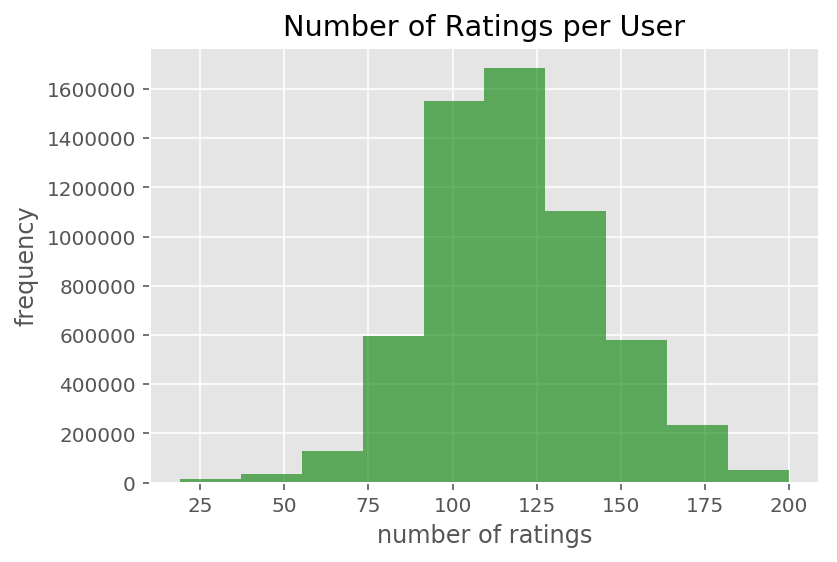

In [3]:
# Visualize the number of reviews per user
eda = merged
eda['number_of_ratings_user'] = eda['user_id'].groupby(eda['user_id']).transform('count')

plt.hist(eda.number_of_ratings_user, alpha = 0.6, color = 'g')
plt.xlabel('number of ratings')
plt.ylabel('frequency')
plt.title('Number of Ratings per User')
plt.show()

<img src="https://github.com/ameenamarie/Goodreads-Recommendation-System/blob/master/reports/figures/fig3.png?raw=true}" title="Weighted Score" width=600 />

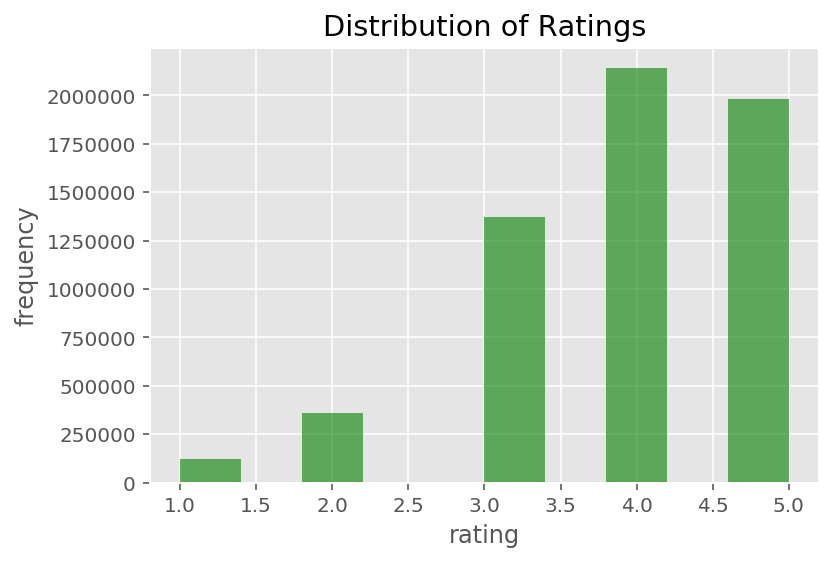

In [4]:
# Visualize the distribution of ratings from users
plt.hist(eda.rating, alpha = 0.6, color='g')
plt.xlabel('rating')
plt.ylabel('frequency')
plt.title('Distribution of Ratings')
plt.show()

<img src="https://github.com/ameenamarie/Goodreads-Recommendation-System/blob/master/reports/figures/fig4.png?raw=true}" title="Weighted Score" width=600 />

In [5]:
# Show the ratings count for the 10 most popular books
eda['number_of_ratings_book'] = eda['book_id'].groupby(eda['book_id']).transform('count')
popular = eda.sort_values('number_of_ratings_book', ascending=False)

# Drop duplicate books
popular = popular.drop_duplicates(subset='book_id', keep="first")
popular = popular[['book_id', 'title', 'number_of_ratings_book']]
popular.head(10)

,book_id,title,number_of_ratings_book
0,1,"The Hunger Games (The Hunger Games, #1)",22806
37375,2,Harry Potter and the Sorcerer's Stone (Harry P...,21850
68674,4,To Kill a Mockingbird,19088
50309,3,"Twilight (Twilight, #1)",16931
91737,5,The Great Gatsby,16604
256286,17,"Catching Fire (The Hunger Games, #2)",16549
301024,20,"Mockingjay (The Hunger Games, #3)",15953
274666,18,Harry Potter and the Prisoner of Azkaban (Harr...,15855
348231,23,Harry Potter and the Chamber of Secrets (Harry...,15657
118906,7,The Hobbit,15558


## Building a simple model

A simple model recommends the same books to all users regardless of their reading or rating history. The recommendations are usually based on the most popular or highest rated items or a score that combines the two. For my simple model, I will be giving each book a weighted score. This will prevent a book with only 10 reviews that are all 5 stars from skewing my results.

To build my model I will be adapting DataCamp's _[IMDB 250 tutorial](https://www.datacamp.com/community/tutorials/recommender-systems-python)_ which gives each item a weighted score using the following formula: 

<img src="https://github.com/ameenamarie/Goodreads-Recommendation-System/blob/master/reports/figures/image1.png?raw=true}" title="Weighted Score" width=400 />

* _v_ number of ratings a book has received;
* _m_ the minimum number of ratings a book needs to receive to be included in the model;
* _R_ the average rating for the book; And
* _C_ the average rating for all books

To start I created a column with the average number of ratings that a book received (*v*) and the average rating that each book received (*R*). I then calculated the average rating for all books (*C*) and identified the books that fall in the 90th quantile (*m*). 

In [6]:
# Create a column for the number of ratings a book has received called 'ratings_count'
merged['ratings_count'] = merged['book_id'].groupby(merged['book_id']).transform('count')

# Create a column for the average rating a book has received called 'average_rating'
merged['average_rating'] = merged['rating'].groupby(merged['book_id']).transform('mean')

# Calculate the average rating for all books
C = merged['rating'].mean()

# Calculate the minimum number of ratings a book needs to receive in order to be included in the model
m = merged['ratings_count'].quantile(0.90)

# Filter the dataset based on value m
filtered = merged.copy().loc[merged['ratings_count'] >= m]

I then built a function that gives a weighted score to each book using the formula above:

In [7]:
# Create a function that gives a weighted score to each book
def weighted_score(x, m=m, C=C):
    v = x['ratings_count']
    R = x['average_rating']
    # Calculation based on an IMDB formula 
    return (v/(v+m) * R) + (m/(m+v) * C)

# Create a 'score' column and give each book a weighted score
filtered['score'] = filtered.apply(weighted_score, axis=1)
filtered.sample(5)

,book_id,title,user_id,rating,number_of_ratings_user,number_of_ratings_book,ratings_count,average_rating,score
620714,48,Fahrenheit 451,27738,5,125,10312,10312,3.931439,3.925753
37294,2,Harry Potter and the Sorcerer's Stone (Harry P...,40940,5,124,21850,21850,4.351350,4.216248
197115,13,1984,27778,4,89,14693,14693,4.046825,3.995532
119927,7,The Hobbit,7448,5,157,15558,15558,4.148477,4.059247
47715,3,"Twilight (Twilight, #1)",6621,5,74,16931,16931,3.214341,3.475656


Once every book had a score, I dropped the duplicates and ranked the books by score. I then identified the ten books with the higest score. 

In [8]:
# Sort books based on score
top10 = filtered.sort_values('score', ascending=False)

# Drop duplicate books
top10 = top10.drop_duplicates(subset='book_id', keep="first")

#Print the top 10 books
top10[['title', 'ratings_count', 'average_rating', 'score']].head(10)

,title,ratings_count,average_rating,score
379644,Harry Potter and the Deathly Hallows (Harry Po...,15304,4.525941,4.287004
402878,Harry Potter and the Half-Blood Prince (Harry ...,15081,4.443339,4.235129
354945,Harry Potter and the Goblet of Fire (Harry Pot...,15523,4.430780,4.231090
262333,Harry Potter and the Prisoner of Azkaban (Harr...,15855,4.418732,4.226258
25217,Harry Potter and the Sorcerer's Stone (Harry P...,21850,4.351350,4.216248
63196,To Kill a Mockingbird,19088,4.329369,4.188958
310931,Harry Potter and the Order of the Phoenix (Har...,15258,4.358697,4.185378
451504,The Help,12727,4.382887,4.179612
20785,"The Hunger Games (The Hunger Games, #1)",22806,4.279707,4.170325
535323,"A Game of Thrones (A Song of Ice and Fire, #1)",10692,4.339880,4.137317


Wow! It looks like everyone really loves Harry Potter. 

If I were to use this model as my recommendation system, Goodreads would recommend these 10 books to every user regardless of their rating or reading history. However, I do not want to recommend Harry Potter to every single user, so I'll be building a collaborative model to get more specific recommendations. 

I can use this simple recommendation model to recommend books to "cold start" users. That is, users who have just joined Goodreads and do not yet have a reading or rating history on the platform. 

## Building a collaborative model from scratch

Collaborative models make recommendations by comparing users and books to each other and grouping by similarity. This is accomplished by measuring the distance between each user and each item in order to group similar users and items together. The model makes multiple calculations for every item in the dataset, so it is best to have a smaller dataset. 

I started by filtering the data to only include users that have reviewed at least 175 books.

In [9]:
# Filter data to only include users who have reviewed at least 175 books
collab = merged
collab['number_of_reviews'] = collab['user_id'].groupby(collab['user_id']).transform('count') 
collab = collab[collab['number_of_reviews'] >= 175]
collab = collab.drop('number_of_reviews', 1)

When I removed users who have rated fewer than 175 books, I had to create a new user index and a new book index so that I could place the ratings for each user and book into a matrix. 

In [10]:
# Create a new column for user_index and book_index
collab = collab.assign(user_index=(collab['user_id']).astype('category').cat.codes)
collab = collab.assign(book_index=(collab['book_id']).astype('category').cat.codes)

n_users = collab.user_id.unique().shape[0]
n_items = collab.book_id.unique().shape[0]
print('DataFrame shape: {}'.format(collab.shape))
print('Number of unique users:', n_users)
print('Number of books:', n_items)
collab.sample(5)

DataFrame shape: (108497, 10)
Number of unique users: 596
Number of books: 7574


,book_id,title,user_id,rating,number_of_ratings_user,number_of_ratings_book,ratings_count,average_rating,user_index,book_index
894013,83,A Tale of Two Cities,16377,5,184,6592,6592,3.782464,222,82
4714368,3564,No One Here Gets Out Alive,46472,2,185,257,257,3.704280,530,3408
2326648,488,The Green Mile,18100,4,186,2744,2744,4.320700,249,487
692138,56,"Breaking Dawn (Twilight, #4)",27900,3,176,9433,9433,3.354924,358,55
1921162,323,The Unbearable Lightness of Being,29671,3,176,3120,3120,3.908654,374,322


The collaborative model requires a matrix using the user_index, book_index, and rating in order to measure the distance between each item and user. I created a training and test matrix. 

In [11]:
# Rearrange the order of the columns to prep for modeling
collab = collab[['user_index', 'book_index', 'rating', 'book_id', 'title', 'user_id', 'ratings_count',
                  'average_rating']]

#from sklearn.cross_validation import train_test_split
train_data, test_data = train_test_split(collab, test_size=0.25)

#Create two user-item matrices, one for training and another for testing
train_data_matrix = np.zeros((n_users, n_items))
for line in train_data.itertuples():
    train_data_matrix[line[1]-1, line[2]-1] = line[3]  

test_data_matrix = np.zeros((n_users, n_items))
for line in test_data.itertuples():
    test_data_matrix[line[1]-1, line[2]-1] = line[3]

Once everything was placed in a train and test matrix, I was able to calculate the similarity between each user or item using pairwise_distance. I used the cosine metric which looks at the cosine of the angle between each item or user. The closer two items are, the larger the cosine. 

In [12]:
# Calculate the similarity using pairwise_distance
user_similarity = pairwise_distances(train_data_matrix, metric='cosine')
item_similarity = pairwise_distances(train_data_matrix.T, metric='cosine')

Now I'm ready to make predictions!

In [13]:
# Define a function to make predictions
def predict(ratings, similarity, type='user'):
    if type == 'user':
        mean_user_rating = ratings.mean(axis=1)
        #We use np.newaxis so that mean_user_rating has same format as ratings
        ratings_diff = (ratings - mean_user_rating[:, np.newaxis])
        pred = mean_user_rating[:, np.newaxis] + similarity.dot(ratings_diff) / np.array([np.abs(similarity).sum(axis=1)]).T
    elif type == 'item':
        pred = ratings.dot(similarity) / np.array([np.abs(similarity).sum(axis=1)])
    return pred

In [14]:
# Make Predictions
user_prediction = predict(train_data_matrix, user_similarity, type='user')
item_prediction = predict(train_data_matrix, item_similarity, type='item')

### Evaluate the model 

Let's see how the model performed:

In [15]:
from sklearn.metrics import mean_squared_error
from math import sqrt

def rmse(prediction, ground_truth):
    prediction = prediction[ground_truth.nonzero()].flatten() 
    ground_truth = ground_truth[ground_truth.nonzero()].flatten()
    return sqrt(mean_squared_error(prediction, ground_truth))

In [16]:
print('User-based CF RMSE: ' + str(rmse(user_prediction, test_data_matrix)))
print('Item-based CF RMSE: ' + str(rmse(item_prediction, test_data_matrix)))

User-based CF RMSE: 3.616775914176882
Item-based CF RMSE: 3.919849318297302


Not bad! Now let's see what kind of recommendations we can get. I'll be printing some recommendations for user 487.

In [17]:
# Create a function for making predictions
def collab_rec(predictions_df, user_id, books_df, original_ratings_df, num_recommendations=5):
    
    # Get and sort the user's predictions
    user_row_number = user_id - 1 # UserID starts at 1, not 0
    sorted_user_predictions = predictions_df.iloc[user_row_number].sort_values(ascending=False)
    
    preds = pd.DataFrame(sorted_user_predictions)
    preds['book_id'] = preds.index + 1
    
    # Get the user's data and merge in the book information.
    user_data = original_ratings_df[original_ratings_df.user_id == (user_id)]
    user_full = (user_data.merge(books_df, how = 'left', left_on = 'book_id', right_on = 'book_id').
                     sort_values(['rating'], ascending=False)
                 )

    print('User {0} has already rated {1} books.'.format(user_id, user_full.shape[0]))
    print('Recommending the highest {0} predicted ratings books not already rated.'.format(num_recommendations))
    
    # Recommend the highest predicted rating books that the user hasn't seen yet.
    recommendations = (books_df[~books_df['book_id'].isin(user_full['book_id'])].
         merge(pd.DataFrame(preds).reset_index(), how = 'left',
               left_on = 'book_id',
              right_on = 'book_id').
         rename(columns = {user_row_number: 'Predictions'}).
         sort_values('Predictions', ascending = False).
                       iloc[:num_recommendations, :-1]
                      )

    return user_full, recommendations

In [18]:
# Make predictions 
user_df = pd.DataFrame(user_prediction)

user_read, recommendations = collab_rec(user_df, 487, books, ratings, 10)

# print books already read by user 487
user_read[['title']].head(10)

User 487 has already rated 136 books.
Recommending the highest 10 predicted ratings books not already rated.


,title
0,The Handmaid's Tale
37,Harry Potter and the Prisoner of Azkaban (Harr...
55,A Thousand Splendid Suns
54,Of Love and Other Demons
107,Animal Farm
52,"The Pigman (The Pigman, #1)"
128,"Fortunately, the Milk"
50,"Plainsong (Plainsong, #1)"
49,A Wolf at the Table
48,The God of Small Things


In [19]:
# Print recommendations for user 487
recommendations[['title']]

,title
12,"The Giver (The Giver, #1)"
7444,"Seduction in Death (In Death, #13)"
4,The Diary of a Young Girl
3,"Divergent (Divergent, #1)"
10,Of Mice and Men
9,Gone Girl
2,Pride and Prejudice
7,"Mockingjay (The Hunger Games, #3)"
20,"The Notebook (The Notebook, #1)"
5,"Catching Fire (The Hunger Games, #2)"


Based on what this user has previously read, I would say these are decent recommendations. Let's see if we can do better with Singular Vector Decomposition. 

## Singular Vector Decomposition Model

The Singular Vector Decomposition model breaks a matrix (like the one used to create the collaborative recommendations above) into its component parts. This allows for more mathematically complex calculations on the matrix later in the modeling process. The matrix is broken down as follows: 

<img src="https://github.com/ameenamarie/Goodreads-Recommendation-System/blob/master/reports/figures/image2.png?raw=true}" title="SVD Formula", width=150 />

* *R* is the user ratings matrix;
* *U* is the user "features" matrix;
* *Σ* is the diagonal matrix of singular values (weights); And
* *Vt* is the books features matrix 

Before I can break the matrix down into its component parts, I need to filter the dataset to only include users who have rated at least 175 books like I did with the collaborative model. 

I will then convert the dataframe into a pivot table with one row for every user and one column for every book. The value in the pivot table is the rating that the user gave a particular book. This pivot table will eventually become the matrix that I will break down. 

In [20]:
svd = merged

# Filter data to only include users who have reviewed at least 175 books 
svd['number_of_reviews'] = svd['user_id'].groupby(svd['user_id']).transform('count') 
svd = svd[svd['number_of_reviews'] >= 175]
svd = svd.drop('number_of_reviews', 1)

# Create a pivot table of users and ratings
pivot = svd.pivot(index = 'user_id', columns ='book_id', values = 'rating').fillna(0)
pivot.head()

book_id,1,2,3,4,5,6,7,8,9,10,...,9981,9984,9985,9988,9990,9991,9992,9994,9995,10000
user_id,,,,,,,,,,,,,,,,,,,,,
35,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
173,4.0,5.0,4.0,4.0,0.0,5.0,0.0,0.0,4.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
274,0.0,0.0,0.0,5.0,5.0,0.0,5.0,4.0,0.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
314,5.0,0.0,3.0,0.0,4.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
368,4.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


To build the matrix, I calculated each user's average rating and then replaced their rating in the matrix with the result of subtracting their average rating from the rating that they gave each book. 

In [21]:
# Convert the pivot table to a matrix
R = pivot.as_matrix()

# Identify a user's average rating 
user_ratings_mean = np.mean(R, axis = 1)
R_demeaned = R - user_ratings_mean.reshape(-1, 1)

/Users/ameenakhan/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


I am now ready to pass the values through the svds model.

In [22]:
from scipy.sparse.linalg import svds
U, sigma, Vt = svds(R_demeaned, k = 50)

sigma = np.diag(sigma)

all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) + user_ratings_mean.reshape(-1, 1)
preds_df = pd.DataFrame(all_user_predicted_ratings, columns = pivot.columns)

Now that I have the predicted ratings for each book, I can start making recommendations. I started by building a function that identifies the row for the desired user, sorts their predicted ratings, removes the books they've already read, and then from the remaining predicted ratings returns the top values as recommendations.

In [23]:
def recommend_books(predictions_df, user_id, books_df, original_ratings_df, num_recommendations=5):
    
    # Get and sort the user's predictions
    user_row_number = user_id - 1 # UserID starts at 1, not 0
    sorted_user_predictions = predictions_df.iloc[user_row_number].sort_values(ascending=False)
    
    # Get the user's data and merge in the book information.
    user_data = original_ratings_df[original_ratings_df.user_id == (user_id)]
    user_full = (user_data.merge(books_df, how = 'left', left_on = 'book_id', right_on = 'book_id').
                     sort_values(['rating'], ascending=False)
                 )

    print('User {0} has already rated {1} books.'.format(user_id, user_full.shape[0]))
    print('Recommending the highest {0} predicted ratings books not already rated.'.format(num_recommendations))
    
    # Recommend the highest predicted rating books that the user hasn't seen yet.
    recommendations = (books_df[~books_df['book_id'].isin(user_full['book_id'])].
         merge(pd.DataFrame(sorted_user_predictions).reset_index(), how = 'left',
               left_on = 'book_id',
              right_on = 'book_id').
         rename(columns = {user_row_number: 'Predictions'}).
         sort_values('Predictions', ascending = False).
                       iloc[:num_recommendations, :-1]
                      )

    return user_full, recommendations

I am going to once again test the function on User 487:

In [24]:
already_rated, recommendations = recommend_books(preds_df, 487, books, ratings, 10)

User 487 has already rated 136 books.
Recommending the highest 10 predicted ratings books not already rated.


In [25]:
# View books the user has already rated
already_rated[['title']].head(10)

,title
0,The Handmaid's Tale
37,Harry Potter and the Prisoner of Azkaban (Harr...
55,A Thousand Splendid Suns
54,Of Love and Other Demons
107,Animal Farm
52,"The Pigman (The Pigman, #1)"
128,"Fortunately, the Milk"
50,"Plainsong (Plainsong, #1)"
49,A Wolf at the Table
48,The God of Small Things


In [26]:
# View the 10 recommended books for User 487
recommendations

,book_id,title
34,63,Wuthering Heights
2,10,Pride and Prejudice
124,171,Emma
45,76,Sense and Sensibility
27,54,The Hitchhiker's Guide to the Galaxy (Hitchhik...
19,43,Jane Eyre
180,230,Persuasion
58,95,The Picture of Dorian Gray
99,142,The Pillars of the Earth (The Kingsbridge Seri...
130,177,Crime and Punishment


## Next Steps

The three models used above only used ratings to determine recommendations. I would like to try and build a model that incorporates book features such as the year of publication, author, genre, and title in order to make more specific recommendations for each user.

I can do this using natural language processing to look for similar words and phrases to group books and make recommendations.  